In [1]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguedashlineups
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import teamdashlineups
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import commonteamroster
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import time

In [2]:
def LineupData(season,per):
    tempdf1 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Advanced',
                                                  season = season, 
                                                  per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Four Factors', 
                                                  season = season,
                                                  per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Misc',
                                                  season = season, 
                                                  per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Scoring', 
                                                  season = season, 
                                                  per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Opponent',
                                                  season = season,
                                                  per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    
    tempdf = pd.merge(tempdf1,tempdf2, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    tempdf1 = tempdf[['GROUP_ID','PLUS_MINUS']].copy()
    
    print("done")
    return(tempdf1)

In [3]:
def LineupData1(season,per):
    tempdf = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf1 = tempdf[['GROUP_ID','GP','PLUS_MINUS']].copy()
    
    print("done")
    return(tempdf1)

In [4]:
def PlayerData(season,per):
    tempdf1 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Advanced', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Usage', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Misc', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Scoring', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Defense', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf = pd.merge(tempdf1,tempdf2, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    print('done')
    return(tempdf)

In [5]:
#Returns dictionary of scores
def nMax(n,playerids,attributes):
    teamscore = 0
    #Loop through players in lineup
    teamAttr = defaultdict(list)
    for player in playerids:
        playerstats = dfPlayer.loc[dfPlayer['PLAYER_ID'] == int(player)]
            
        for attr in attributes:
            playerscore = playerstats.iloc[0][attr]
            teamAttr[attr].append(playerscore)

    rawAttr = defaultdict()
    for x in teamAttr:
        teamAttr[x].sort(reverse = True)
        teamAttr[x] = teamAttr[x][:n]
        rawAttr[x] = sum(teamAttr[x][:n])
    return(rawAttr)

In [31]:
def Train(df,attributes):
    for index, row in df.iterrows():
        playerids = row['GROUP_ID'].split("-")[1:-1]
        
        info = nMax(2,playerids,attributes)

        for key,value in info.items():
            df.at[index,key] = value
            
    return(df)

In [32]:
def ScoreCalc(df,attributes):
    df1 = Train(df,attributes)
    df1 = df1.loc[(df1['GP'] >= 10)]
    
    coeff = {}
    for attr in attributes:
        model = sm.OLS(df1['PLUS_MINUS'],df1[attr]).fit()
        val = model.tvalues[0] 
        coeff[attr] = val
    
    #calculate the scores
    df1['Score'] = (coeff[attributes[0]]*df1[attributes[0]] + coeff[attributes[1]]*df1[attributes[1]] + 
        coeff[attributes[2]]*df1[attributes[2]] + coeff[attributes[3]]*df1[attributes[3]] + 
        coeff[attributes[4]]*df1[attributes[4]] + coeff[attributes[5]]*df1[attributes[5]] + 
        coeff[attributes[6]]*df1[attributes[6]] + coeff[attributes[7]]*df1[attributes[7]])
    
#     df1['score'] = df1.apply(lambda x: coeff[attributes[0]]*df1[attributes[0]] + coeff[attributes[1]]*df1[attributes[1]] + 
#         coeff[attributes[2]]*df1[attributes[2]] + coeff[attributes[3]]*df1[attributes[3]] + 
#         coeff[attributes[4]]*df1[attributes[4]], axis=1)
    
    return(df1)
        

In [34]:
def GetLineups(season):
    nba_teams = teams.get_teams()

    teamLineups = defaultdict(str)
    for team in nba_teams:
        teamid = team['id']
        teamdf = teamdashlineups.TeamDashLineups(team_id = teamid, season = season, per_mode_detailed = 'Totals').get_data_frames()[1]
        #print(teamdf.head())
        teamdf.sort_values('MIN',ascending = False)
        teamLineups[team['abbreviation']] = teamdf.iat[0,1].split("-")[1:-1]
        #print("done")
        #print(teamLineups)
        time.sleep(1)
    
    print("done")
    return(teamLineups)

In [35]:
def getPlayerInfo(df):
    nba_teams = teams.get_teams()
    tempdf = pd.DataFrame()

    for team in nba_teams:
        teamid = team['id']
        roster = commonteamroster.CommonTeamRoster(team_id = teamid,season = '2017-18').get_data_frames()[0]
        tempdf = tempdf.append(roster)

        time.sleep(1)

    newRoster = tempdf[['PLAYER_ID','HEIGHT','EXP']].copy()
    df = df.merge(newRoster,on='PLAYER_ID',how='left')
    print("done")
    return(df)


In [42]:
dfLineup = LineupData1('2017-18','Per100Possessions')
dfPlayer = PlayerData('2017-18','Per100Possessions')
dfPlayer = getPlayerInfo(dfPlayer)
teamLineups = GetLineups('2017-18')
print(len(dfLineup))
print(len(dfPlayer))
len(teamLineups)
print(list(dfPlayer.columns))

done
done
done
done
2000
540
['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3', 'CFID', 'CFPARAMS', 'eOFF_RATING', 'OFF_RATING', 'sp_work_OFF_RATING', 'eDEF_RATING', 'DEF_RATING', 'sp_work_DEF_RATING', 'eNET_RATING', 'NET_RATING', 'sp_work_NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'ePACE', 'PACE', 'sp_work_PACE', 'PIE', 'FGM_PG', 'FGA_PG', 'PCT_FGM', 'PCT_FGA', 'PCT_FG3M', 'PCT_FG3A', 'PCT_FTM', 'PCT_FTA', 'PCT_OREB', 'PCT_DREB', 'PCT_REB', 'PCT_AST', 'PCT_TOV', 'PCT_STL', 'PCT_BLK', 'PCT_BLKA', 'PCT_PF', 'PCT_PFD', 'PCT_PTS', 'PTS_OFF_TOV', 'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT', 'OPP_PTS_OFF_TOV', 'OPP_PTS_2ND_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT', 'PC

In [49]:
for index, row in dfPlayer.iterrows():
    if pd.isnull(row['HEIGHT']):
        dfPlayer.at[index,'HEIGHT'] = 0   
    else:
        feet = row['HEIGHT'].split('-')[0]
        #print(feet)
        inches = row['HEIGHT'].split('-')[1]
        dfPlayer.at[index,'HEIGHT'] = 12*int(feet) + int(inches)    
    exp = row['EXP']
    if exp == 'R' or pd.isnull(exp):
        dfPlayer.at[index,'EXP'] = 0
    else:
        dfPlayer.at[index,'EXP'] = int(exp)


In [50]:
dfPlayer.head(10)

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DEF_WS,HEIGHT,EXP
0,201166,Aaron Brooks,1610612750,MIN,33.0,32,19,13,0.594,47.1,...,0.240,0.118,0.882,0.818,0.182,0.393,0.607,0.014,72,9
1,203932,Aaron Gordon,1610612753,ORL,22.0,58,19,39,0.328,47.6,...,0.407,0.488,0.512,0.835,0.165,0.595,0.405,0.129,81,3
2,1626151,Aaron Harrison,1610612742,DAL,23.0,9,2,7,0.222,48.6,...,0.233,0.300,0.700,1.000,0.000,0.632,0.368,0.066,78,2
3,1628935,Aaron Jackson,1610612745,HOU,32.0,1,0,1,0.000,51.5,...,0.500,0.500,0.500,0.000,1.000,0.333,0.667,0.146,75,0
4,1627846,Abdel Nader,1610612738,BOS,24.0,48,33,15,0.688,47.2,...,0.342,0.333,0.667,0.957,0.043,0.620,0.380,0.150,78,0
5,203940,Adreian Payne,1610612753,ORL,27.0,5,0,5,0.000,48.9,...,0.286,0.800,0.200,1.000,0.000,0.857,0.143,0.026,0,0
6,201143,Al Horford,1610612738,BOS,32.0,72,47,25,0.653,49.1,...,0.444,0.572,0.428,0.948,0.052,0.671,0.329,0.233,82,10
7,2744,Al Jefferson,1610612754,IND,33.0,36,17,19,0.472,48.4,...,0.619,0.595,0.405,0.000,0.000,0.595,0.405,0.152,82,13
8,202329,Al-Farouq Aminu,1610612757,POR,27.0,69,40,29,0.580,48.4,...,0.307,0.486,0.514,0.960,0.040,0.743,0.257,0.187,81,7
9,1626210,Alan Williams,1610612756,PHX,25.0,5,1,4,0.200,48.5,...,0.700,0.857,0.143,0.000,0.000,0.857,0.143,0.380,80,2


In [85]:
attributes = ['AST','OREB','DREB','BLK','FG_PCT','FG3_PCT','STL','TOV','OFF_RATING','DEF_RATING','PF','PTS','HEIGHT','EXP']
rand = nMax(2,['2585', '201142', '201939', '202691', '203110'],attributes)
print(rand)

defaultdict(None, {'AST': 18.9, 'OREB': 5.8, 'DREB': 20.4, 'BLK': 4.2, 'FG_PCT': 1.08, 'FG3_PCT': 0.863, 'STL': 4.1, 'TOV': 8.5, 'OFF_RATING': 235.5, 'DEF_RATING': 215.3, 'PF': 9.6, 'PTS': 73.5, 'HEIGHT': 164, 'EXP': 24})


In [86]:
for key, value in teamLineups.items():
    vals = nMax(2,value,attributes)


#Calculate score for each team
teamRank = defaultdict(int)
for key, value in teamLineups.items():
    vals = nMax(2,value,attributes)
    
    coeffs = {
        'AST': 8,
        'OREB': 20,
        'DREB': 1,
        'BLK': 20,
        'FG_PCT':120,
        'FG3_PCT':200,
        'STL':20,
        'TOV':-15, 
        'OFF_RATING':.5,
        'DEF_RATING':-.3,
        'PF': 10,
        'PTS': 2,
        'HEIGHT':1,
        'EXP':5 
    }
    
    score = 0
    test = {}
    for key1,value1 in vals.items():
        score = score + (coeffs[key1]*value1)
        test[key1] = coeffs[key1]*value1
    teamRank[key] = score
    
print(teamRank)
print(test)

defaultdict(<class 'int'>, {'ATL': 1041.64, 'BOS': 1117.4199999999998, 'CLE': 1097.7, 'NOP': 1162.99, 'CHI': 1008.86, 'DAL': 1030.04, 'DEN': 1083.27, 'GSW': 1208.46, 'HOU': 1260.8000000000002, 'LAC': 1119.8600000000001, 'LAL': 996.5400000000001, 'MIA': 1256.02, 'MIL': 1104.45, 'MIN': 1159.8200000000002, 'BKN': 1035.63, 'NYK': 1196.2200000000003, 'ORL': 1029.24, 'IND': 1136.79, 'PHI': 1096.49, 'PHX': 1111.77, 'POR': 1052.73, 'SAC': 990.1099999999999, 'SAS': 1128.9099999999999, 'OKC': 1226.5, 'TOR': 1169.5900000000001, 'UTA': 1172.8899999999999, 'MEM': 1049.2599999999998, 'WAS': 1081.8300000000002, 'DET': 1086.18, 'CHA': 1140.9099999999999})
{'AST': 129.6, 'OREB': 144.0, 'DREB': 21.7, 'BLK': 68.0, 'FG_PCT': 127.08000000000001, 'FG3_PCT': 159.39999999999998, 'STL': 64.0, 'TOV': -106.5, 'OFF_RATING': 109.80000000000001, 'DEF_RATING': -64.77, 'PF': 85.0, 'PTS': 114.6, 'HEIGHT': 164, 'EXP': 125}


In [87]:
#Get log of all the games for the season
games = leaguegamelog.LeagueGameLog(season_all_time = '2017-18').get_data_frames()[0]
games.drop_duplicates('GAME_ID',inplace = True)
dummy = pd.get_dummies(games['WL'])
games = pd.concat([games,dummy],axis = 1)
print(len(games))
games.head()

1230


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,L,W
0,22017,1610612744,GSW,Golden State Warriors,0021700002,2017-10-17,GSW vs. HOU,L,240,43,...,34,5,9,17,25,121,-1,1,1,0
2,22017,1610612738,BOS,Boston Celtics,0021700001,2017-10-17,BOS @ CLE,L,240,36,...,24,11,4,12,24,99,-3,1,1,0
4,22017,1610612759,SAS,San Antonio Spurs,0021700011,2017-10-18,SAS vs. MIN,W,240,41,...,22,8,11,11,18,107,8,1,0,1
6,22017,1610612738,BOS,Boston Celtics,0021700007,2017-10-18,BOS vs. MIL,L,240,39,...,23,12,2,15,27,100,-8,1,1,0
8,22017,1610612757,POR,Portland Trail Blazers,0021700012,2017-10-18,POR @ PHX,W,240,44,...,22,8,7,18,20,124,48,1,0,1


In [88]:
#Add in Scores to games
for index, row in games.iterrows():
    home = row['MATCHUP'].split(' ')[0]
    away = row['MATCHUP'].split(' ')[2]
    games.at[index,'homeScore'] = teamRank[home]
    games.at[index,'awayScore'] = teamRank[away]
    games.at[index,'netScore'] = teamRank[home] - teamRank[away]
    
games.head(10)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,L,W,homeScore,awayScore,netScore
0,22017,1610612744,GSW,Golden State Warriors,0021700002,2017-10-17,GSW vs. HOU,L,240,43,...,17,25,121,-1,1,1,0,1208.46,1260.80,-52.34
2,22017,1610612738,BOS,Boston Celtics,0021700001,2017-10-17,BOS @ CLE,L,240,36,...,12,24,99,-3,1,1,0,1117.42,1097.70,19.72
4,22017,1610612759,SAS,San Antonio Spurs,0021700011,2017-10-18,SAS vs. MIN,W,240,41,...,11,18,107,8,1,0,1,1128.91,1159.82,-30.91
6,22017,1610612738,BOS,Boston Celtics,0021700007,2017-10-18,BOS vs. MIL,L,240,39,...,15,27,100,-8,1,1,0,1117.42,1104.45,12.97
8,22017,1610612757,POR,Portland Trail Blazers,0021700012,2017-10-18,POR @ PHX,W,240,44,...,18,20,124,48,1,0,1,1052.73,1111.77,-59.04
10,22017,1610612766,CHA,Charlotte Hornets,0021700003,2017-10-18,CHA @ DET,L,240,29,...,17,15,90,-12,1,1,0,1140.91,1086.18,54.73
12,22017,1610612748,MIA,Miami Heat,0021700005,2017-10-18,MIA @ ORL,L,240,44,...,13,20,109,-7,1,1,0,1256.02,1029.24,226.78
14,22017,1610612751,BKN,Brooklyn Nets,0021700004,2017-10-18,BKN @ IND,L,240,45,...,20,25,131,-9,1,1,0,1035.63,1136.79,-101.16
16,22017,1610612737,ATL,Atlanta Hawks,0021700009,2017-10-18,ATL @ DAL,W,240,48,...,13,18,117,6,1,0,1,1041.64,1030.04,11.60
18,22017,1610612762,UTA,Utah Jazz,0021700010,2017-10-18,UTA vs. DEN,W,240,41,...,15,18,106,10,1,0,1,1172.89,1083.27,89.62


In [96]:
exog = sm.add_constant(games['netScore'])

model = sm.OLS(games['PLUS_MINUS'],games['netScore']).fit()
model1 = sm.Logit(games['W'],games['netScore']).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 37.525510
         Iterations 4


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      W   No. Observations:                 1230
Model:                          Logit   Df Residuals:                     1229
Method:                           MLE   Df Model:                            0
Date:                Thu, 21 Feb 2019   Pseudo R-squ.:                     inf
Time:                        23:14:14   Log-Likelihood:                -46156.
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
netScore       0.0052      0.001      8.791      0.000       0.004       0.006
==============================================================================
"""

Text(0, 0.5, 'Plus - Minus')

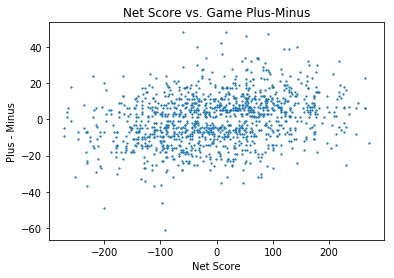

In [97]:
plt.figure(1)
plt.scatter(games['netScore'],games['PLUS_MINUS'],s = 1.5)
plt.title("Net Score vs. Game Plus-Minus")
plt.xlabel("Net Score")
plt.ylabel("Plus - Minus")

In [91]:
total = 0
correct = 0 
for index, row in games.iterrows():
    if row['W'] == 1 and row['netScore'] > 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 0 and row['netScore'] < 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 1 and row['netScore'] < 0:
        total = total + 1
    elif row['W'] == 0 and row['netScore'] > 0:
        total = total + 1
print(correct)
print(total)
print(correct/total)

757
1230
0.6154471544715447


In [92]:
roster = commonteamroster.CommonTeamRoster(1610612744).get_data_frames()[0]

roster.head(20)

,TeamID,SEASON,LeagueID,PLAYER,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID
0,1610612744,2018,00,DeMarcus Cousins,0,C,6-11,270,"AUG 13, 1990",28.0,8,Kentucky,202326
1,1610612744,2018,00,Damion Lee,1,G,6-6,210,"OCT 21, 1992",26.0,1,Louisville,1627814
2,1610612744,2018,00,Jordan Bell,2,F,6-9,224,"JAN 07, 1995",24.0,1,Oregon,1628395
3,1610612744,2018,00,Quinn Cook,4,G,6-2,179,"MAR 23, 1993",25.0,2,Duke,1626188
4,1610612744,2018,00,Kevon Looney,5,C-F,6-9,220,"FEB 06, 1996",23.0,3,UCLA,1626172
5,1610612744,2018,00,Andre Iguodala,9,G-F,6-6,215,"JAN 28, 1984",35.0,14,Arizona,2738
6,1610612744,2018,00,Jacob Evans,10,G,6-6,210,"JUN 18, 1997",21.0,R,Cincinnati,1628980
7,1610612744,2018,00,Klay Thompson,11,G,6-7,215,"FEB 08, 1990",29.0,7,Washington State,202691
8,1610612744,2018,00,Damian Jones,15,C,7-0,245,"JUN 30, 1995",23.0,2,Vanderbilt,1627745
9,1610612744,2018,00,Jonas Jerebko,21,F,6-10,231,"MAR 02, 1987",31.0,8,"Kinna, Sweden",201973


In [93]:
from nba_api.stats.endpoints import leaguestandings

stand = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]
print(list(stand.columns))
nba_teams = teams.get_teams()

nba_teams = teams.get_teams()
print(type(nba_teams))

lookup = {}
for team in nba_teams:
    teamid = team['id']
    lookup[team['nickname']] = team['abbreviation']

for index, row in stand.iterrows():
    name = row['TeamName']
    abbrev = lookup[name]
    stand.at[index,'score'] = teamRank[abbrev]
    
#     away = row['MATCHUP'].split(' ')[2]
#     games.at[index,'homeScore'] = teamRank[home]
#     games.at[index,'awayScore'] = teamRank[away]
#     games.at[index,'netScore'] = teamRank[home] - teamRank[away]


print(list(stand['WINS']))
stand.head()

['LeagueID', 'SeasonID', 'TeamID', 'TeamCity', 'TeamName', 'Conference', 'ConferenceRecord', 'PlayoffRank', 'ClinchIndicator', 'Division', 'DivisionRecord', 'DivisionRank', 'WINS', 'LOSSES', 'WinPCT', 'LeagueRank', 'Record', 'HOME', 'ROAD', 'L10', 'Last10Home', 'Last10Road', 'OT', 'ThreePTSOrLess', 'TenPTSOrMore', 'LongHomeStreak', 'strLongHomeStreak', 'LongRoadStreak', 'strLongRoadStreak', 'LongWinStreak', 'LongLossStreak', 'CurrentHomeStreak', 'strCurrentHomeStreak', 'CurrentRoadStreak', 'strCurrentRoadStreak', 'CurrentStreak', 'strCurrentStreak', 'ConferenceGamesBack', 'DivisionGamesBack', 'ClinchedConferenceTitle', 'ClinchedDivisionTitle', 'ClinchedPlayoffBirth', 'EliminatedConference', 'EliminatedDivision', 'AheadAtHalf', 'BehindAtHalf', 'TiedAtHalf', 'AheadAtThird', 'BehindAtThird', 'TiedAtThird', 'Score100PTS', 'OppScore100PTS', 'OppOver500', 'LeadInFGPCT', 'LeadInReb', 'FewerTurnovers', 'PointsPG', 'OppPointsPG', 'DiffPointsPG', 'vsEast', 'vsAtlantic', 'vsCentral', 'vsSoutheast

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS,score
0,00,22017,1610612761,Toronto,Raptors,East,40-12,1,- e,Atlantic,...,None,None,None,None,4-2,9-5,11-3,41-16,18-7,1169.59
1,00,22017,1610612745,Houston,Rockets,West,41-11,1,- w,Southwest,...,None,None,None,None,5-3,12-1,9-5,44-13,21-4,1260.80
2,00,22017,1610612744,Golden State,Warriors,West,34-18,2,- p,Pacific,...,None,None,None,None,5-3,11-3,13-2,44-14,14-10,1208.46
3,00,22017,1610612738,Boston,Celtics,East,33-19,2,- x,Atlantic,...,None,None,None,None,5-2,14-2,11-6,40-19,15-8,1117.42
4,00,22017,1610612757,Portland,Trail Blazers,West,31-21,3,- nw,Northwest,...,None,None,None,None,4-3,9-6,5-8,32-26,17-7,1052.73


In [94]:
model2 = sm.OLS(stand['WINS'],stand['score']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   WINS   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     450.7
Date:                Thu, 21 Feb 2019   Prob (F-statistic):           3.23e-19
Time:                        23:13:03   Log-Likelihood:                -113.12
No. Observations:                  30   AIC:                             228.2
Df Residuals:                      29   BIC:                             229.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          0.0372      0.002     21.231      0.000       0.034       0.041
==============================================================================
Omnibus:                        3.041   Durbin-Watson:                   0.239
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                1.544
Skew:                          -0.213   Prob(JB):                        0.462
Kurtosis:                       1.974   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Wins')

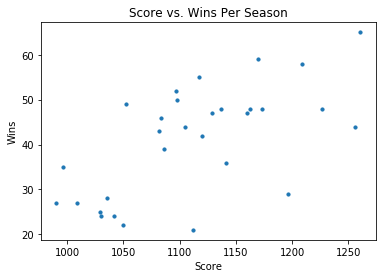

In [99]:
plt.figure(1)
plt.scatter(stand['score'],stand['WINS'],s = 10)
plt.title("Score vs. Wins Per Season")
plt.xlabel("Score")
plt.ylabel("Wins")